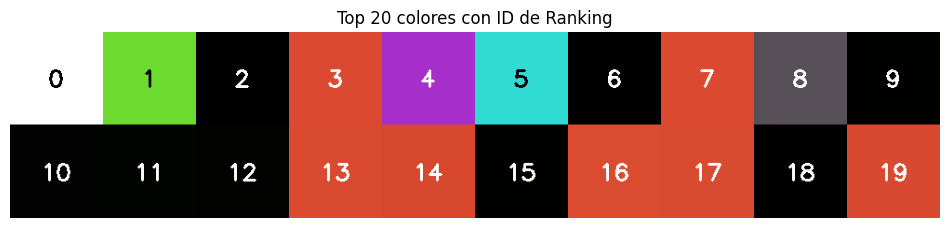

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_text_color(rgb):
    # Fórmula de luminancia: 0.299*R + 0.587*G + 0.114*B
    luminance = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    return (255, 255, 255) if luminance < 128 else (0, 0, 0)

def get_exact_color_counts(image_path, top_n=20):
    # 1. Cargar imagen y convertir a RGB
    img = cv2.imread(image_path)
    if img is None:
        print("Error: No se pudo cargar la imagen.")
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = img.reshape(-1, 3)
    pixels_tuple = [tuple(p) for p in pixels]
    
    # 2. Contar ocurrencias
    counts = Counter(pixels_tuple)
    total_pixels = len(pixels)
    sorted_counts = counts.most_common()
    
    # 3. Preparar datos para el DataFrame y la visualización
    data_list = []
    display_colors = []
    
    for i, (color, count) in enumerate(sorted_counts):
        if i >= top_n: break
        
        hex_code = rgb_to_hex(color)
        percentage = (count / total_pixels) * 100
        
        # Guardar para el DataFrame
        data_list.append({
            'ID': i,
            'HEX': hex_code,
            'Porcentaje': percentage,
            'RGB': color
        })
        
        display_colors.append({'rgb': color, 'percentage': percentage})

    # Crear el DataFrame
    df = pd.DataFrame(data_list)

    # 4. Crear imagen con cuadraditos y números
    rows = 2
    cols = top_n // rows
    square_size = 100
    canvas = np.ones((rows * square_size, cols * square_size, 3), dtype="uint8") * 255
    
    for i in range(top_n):
        if i >= len(display_colors): break
        r = i // cols
        c = i % cols
        color = display_colors[i]['rgb']
        
        x1, y1 = c * square_size, r * square_size
        x2, y2 = (c + 1) * square_size, (r + 1) * square_size
        
        cv2.rectangle(canvas, (x1, y1), (x2, y2), [int(x) for x in color], -1)
        
        txt_color = get_text_color(color)
        text = str(i)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        
        text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
        text_x = x1 + (square_size - text_size[0]) // 2
        text_y = y1 + (square_size + text_size[1]) // 2
        
        cv2.putText(canvas, text, (text_x, text_y), font, font_scale, txt_color, thickness)

    # Mostrar la imagen
    plt.figure(figsize=(12, 6))
    plt.imshow(canvas)
    plt.title(f"Top {top_n} colores con ID de Ranking")
    plt.axis("off")
    plt.show()

    return df

# --- Ejecución ---
# Ahora la función devuelve el DataFrame que puedes guardar en una variable
df_colores = get_exact_color_counts('./cat_base/2a.png', top_n=20)


In [ ]:
import cv2
import numpy as np
import os

def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))

def get_next_cat_dir(base_name="cat_"):
    """Crea la siguiente carpeta cat_N"""
    existing = [d for d in os.listdir('.') if os.path.isdir(d) and d.startswith(base_name)]
    indices = [int(d.split('_')[1]) for d in existing if "_" in d and d.split('_')[1].isdigit()]
    next_idx = max(indices) + 1 if indices else 1
    new_folder = f"{base_name}{next_idx}"
    os.makedirs(new_folder, exist_ok=True)
    return new_folder

def process_batch_final(or_dir, df_colores, similar_colors, replace_dict):
    output_dir = get_next_cat_dir()
    print(f"--- Guardando en: {output_dir} ---")

    # 1. Crear el diccionario de mapeo RGB_original -> RGB_nuevo
    # Usamos los datos exactos del df_colores (tu imagen de referencia)
    mapping_rgb = {}
    for group_idx, group_list in enumerate(similar_colors):
        if group_idx in replace_dict:
            new_rgb = hex_to_rgb(replace_dict[group_idx])
            for color_id in group_list:
                # Sacamos el RGB que corresponde a ese ID en el DataFrame
                row = df_colores.loc[df_colores['ID'] == color_id]
                if not row.empty:
                    ref_rgb = tuple(row['RGB'].values[0])
                    mapping_rgb[ref_rgb] = new_rgb

    # 2. Procesar las imágenes de la carpeta
    for img_name in os.listdir(or_dir):
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        img_path = os.path.join(or_dir, img_name)
        
        # LEER CON CANAL ALPHA (IMPORTANTE)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None: continue

        # Separar canales: trabajamos el color y guardamos el alpha aparte
        if img.shape[2] == 4:
            # BGRA
            bgr = img[:, :, :3]
            alpha = img[:, :, 3]
        else:
            # BGR normal
            bgr = img
            alpha = None

        # Pasamos a RGB para comparar con el DataFrame
        rgb_img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        new_rgb_img = rgb_img.copy()

        # 3. Reemplazar colores según el mapeo
        for orig_rgb, target_rgb in mapping_rgb.items():
            mask = np.all(rgb_img == orig_rgb, axis=-1)
            new_rgb_img[mask] = target_rgb

        # Volver a BGR para OpenCV
        final_bgr = cv2.cvtColor(new_rgb_img, cv2.COLOR_RGB2BGR)

        # 4. Re-ensamblar con la transparencia original
        if alpha is not None:
            final_img = cv2.merge([final_bgr[:,:,0], final_bgr[:,:,1], final_bgr[:,:,2], alpha])
        else:
            final_img = final_bgr

        # 5. Guardar
        save_path = os.path.join(output_dir, os.path.splitext(img_name)[0] + ".png")
        cv2.imwrite(save_path, final_img)
        print(f"Procesada: {img_name}")


--- Guardando en: cat_1 ---
Procesada: 4a.png
Procesada: 5a.png
Procesada: 3a.png
Procesada: 2a.png


In [ ]:

similar_colors = [
    [1], # Grupo 0 -> Verde
    [2, 6, 9, 10, 11, 12, 15, 18], # Grupo 1 -> Negro
    [3, 7, 13, 14, 16, 17, 19], # Grupo 2 -> Rojo
    [4], # Grupo 3 -> Violeta
    [5]  # Grupo 4 -> Celeste
]

# Nota: El índice aquí (0, 1, 2...) corresponde a la posición en similar_colors
replace_dicts = [{
    0: "#e69b32", # El Grupo 0 (Verde) ahora es Naranja
    2: "#6b4f27", # El Grupo 2 (Rojo) ahora es Azul
    3: "#2eb9d9", # El Grupo 3 (Violeta) ahora es Crema
    4: "#e3b676",  # El Grupo 4 (Celeste) ahora es Marrón
},
{
    0: "#ffffff", # El Grupo 0 (Verde) ahora es Naranja
    2: "#949494", # El Grupo 2 (Rojo) ahora es Azul
    3: "#22b685", # El Grupo 3 (Violeta) ahora es Crema
    4: "#949494",  # El Grupo 4 (Celeste) ahora es Marrón
},
{
    0: "#e2d18b", # El Grupo 0 (Verde) ahora es Naranja
    2: "#543F24", # El Grupo 2 (Rojo) ahora es Azul
    3: "#21d727", # El Grupo 3 (Violeta) ahora es Crema
    4: "#949494",  # El Grupo 4 (Celeste) ahora es Marrón
}]

replace_dict = replace_dicts[2]

# Ejecutar usando el df_colores que generaste previamente
process_batch_final("./cat_base/", df_colores, similar_colors, replace_dict)

--- Guardando en: cat_3 ---
Procesada: 4a.png
Procesada: 5a.png
Procesada: 3a.png
Procesada: 2a.png
